In [1]:
'''load packages'''
import pandas as pd
import numpy as np
import os
from gensim.models import word2vec
import torch.nn as nn
import torch
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch import nn, optim
from sklearn.metrics import accuracy_score, average_precision_score,precision_score,f1_score,roc_auc_score
from torchsummary import summary
from sklearn.preprocessing import label_binarize

In [2]:
context_size = 36  # 句子长度（字词个数）
num_embeddings = 7102  # 词典的大小(vocab_size)
LARGE_SENTENCE_SIZE = 36  # 句子最大长度
BATCH_SIZE = 64          # 语料批次大小
LEARNING_RATE = 0.0001   # 学习率大小
EMBEDDING_SIZE = 50      # 词向量维度
KERNEL_LIST = [2,3,4]   # 卷积核长度
FILTER_NUM = 100          # 每种卷积核输出通道数
DROPOUT = 0.5             # dropout概率
EPOCH = 50                # 训练轮次

In [3]:
# data=pd.read_csv("D:\\jupyter notebook\\trb.csv")
data=pd.read_csv("D:\\jupyter notebook\\prediction.csv")

In [4]:
data

,cdr3,crd3_encode,j.segm,v.seg,mhc.a,mhc.b,v.seg_0,v.seg_1,v.seg_2,v.seg_3,...,mhc.a_1,mhc.a_2,mhc.a_3,mhc.a_4,mhc.a_5,mhc.a_6,mhc.b_label,mhc.class,antigen.epitope,vdjdb.score
0,CAAAERNTGELFF,"[-0.16498591005802155, -0.1462753862142563, 0....",TRBJ2-2*01,TRBV28*01,HLA-A*02,B2M,0,1,1,0,...,0,0,0,1,0,0,0,0,YLQPRTFLL,0
1,CAAEDPEWGAEAFF,"[-0.24984240531921387, 0.38962453603744507, -0...",TRBJ1-1*01,TRBV30*01,HLA-A*03:01,B2M,0,1,1,0,...,0,0,1,1,1,1,0,0,KLGGALQAK,0
2,CAAGAGLSYEQYF,"[-0.7613160014152527, 0.263674259185791, -0.52...",TRBJ2-7*01,TRBV27*01,HLA-A*02,B2M,0,1,0,1,...,0,0,0,1,0,0,0,0,NLVPMVATV,0
3,CAAGDANTGELFF,"[-0.7613160014152527, 0.263674259185791, -0.52...",TRBJ2-2*01,TRBV5-1*01,HLA-A*02:01,B2M,0,1,1,1,...,0,0,0,1,0,1,0,0,YLQPRTFLL,0
4,CAAGEMFGLGETQYF,"[-0.7613160014152527, 0.263674259185791, -0.52...",TRBJ2-5*01,TRBV4-2*01,HLA-A*03:01,B2M,0,1,1,1,...,0,0,1,1,1,1,0,0,KLGGALQAK,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29760,CVTGQGDINEQFF,"[0.07739217579364777, 0.0676565170288086, 0.14...",TRBJ2-1*01,TRBV11-1*01,HLA-A*03:01,B2M,0,0,0,1,...,0,0,1,1,1,1,0,0,KLGGALQAK,0
29761,CVTSAPLRQGLFNYGYTF,"[0.17337776720523834, 0.1124500036239624, 0.03...",TRBJ1-2*01,TRBV24-1*01,HLA-A*02,B2M,0,1,0,1,...,0,0,0,1,0,0,0,0,GILGFVFTL,0
29762,CWGNTEAFF,"[-0.13605011999607086, 0.22847767174243927, 0....",TRBJ1-1*01,TRBV12-4*01,HLA-A*03:01,B2M,0,0,1,0,...,0,0,1,1,1,1,0,0,KLGGALQAK,0
29763,IPDTGELFF,"[0.6372780799865723, 0.36321160197257996, 0.24...",TRBJ2-2*01,TRBV3-1*01,HLA-DPA*01:03,HLA-DPB*04:01,0,1,1,0,...,0,1,0,0,1,0,1,1,TFEYVSQPFLMDLE,0


In [5]:
# data=pd.read_csv('cleaned_data.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29765 entries, 0 to 29764
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   cdr3             29765 non-null  object
 1   crd3_encode      29765 non-null  object
 2   j.segm           29765 non-null  object
 3   v.seg            29765 non-null  object
 4   mhc.a            29765 non-null  object
 5   mhc.b            29765 non-null  object
 6   v.seg_0          29765 non-null  int64 
 7   v.seg_1          29765 non-null  int64 
 8   v.seg_2          29765 non-null  int64 
 9   v.seg_3          29765 non-null  int64 
 10  v.seg_4          29765 non-null  int64 
 11  v.seg_5          29765 non-null  int64 
 12  j.segm_0         29765 non-null  int64 
 13  j.segm_1         29765 non-null  int64 
 14  j.segm_2         29765 non-null  int64 
 15  j.segm_3         29765 non-null  int64 
 16  mhc.a_0          29765 non-null  int64 
 17  mhc.a_1          29765 non-null

In [7]:
data['antigen.epitope'].value_counts()

KLGGALQAK               12740
NLVPMVATV                4776
GILGFVFTL                3739
AVFDRKSDAK               1652
ELAGIGILTV               1444
GLCTLVAML                1086
YLQPRTFLL                 977
RAKFKQLL                  875
IVTDFSVIK                 553
SPRWYFYYL                 543
KRWIILGLNK                484
TFEYVSQPFLMDLE            453
FRDYVDRFYKTLRAEQASQE      443
Name: antigen.epitope, dtype: int64

In [8]:
# data = data[data['antigen.epitope'].map(data['antigen.epitope'].value_counts(normalize=True)) > 0.1] #drop the clusters with little data

In [9]:
from collections import Counter
Counter(list(data.groupby(by=['cdr3','j.segm','mhc.a','mhc.b','mhc.class','v.seg'])['antigen.epitope'].count()))

Counter({1: 29360, 2: 198, 3: 3})

In [10]:
def generate_kmers(sequence, k):
    """Generate k-mers for a given sequence."""
    return [sequence[i:i+k] for i in range(len(sequence)-k+1)]
k=3 # change the k for kmers
all_kmers = [kmer for seq in data['cdr3'] for kmer in generate_kmers(seq, k)]

# Count the frequency of each 4-mer
kmer_counts = Counter(all_kmers)

In [11]:
sentence=[]
for seq in data['cdr3']:
    temp=generate_kmers(seq,k)
    sentence.append(temp)
f=open('kmer_3.txt','w')
f.writelines('\n'.join([' '.join(l) for l in sentence]))
'''add to data'''
data=data.reset_index()
data['kmers']=pd.Series(sentence)

In [12]:
len(sentence)

29765

In [13]:
from gensim.models import Word2Vec
kmer_model=Word2Vec.load('.\model\kmer_word2vec_50.model')

In [14]:
# def embedding(data,model):
#     vec=[]
#     vectors = model.wv
#     length=data.map(len).max()
#     for sentence in list(data):
#         sentence=list(sentence)
#         sentence_vector=[vectors[i] for i in sentence]
# #         print(len(sentence_vector))
#         while len(sentence_vector)<length:
#             sentence_vector.append(np.zeros_like(vectors[sentence[0]]))
# #         print(sentence_vector)
#         vec.append(sentence_vector)
#     return vec

In [15]:
# trb_embed=embedding(data['kmers'],kmer_model)
# data['kmers']=trb_embed

In [16]:
# #copy data according to score
# data=pd.concat([data,data[data['vdjdb.score']==1]])
# data=pd.concat([data,data[data['vdjdb.score']==2]])
# data=pd.concat([data,data[data['vdjdb.score']==2]])

----------------------------finish data processing

### only use cdr

In [17]:
# 将词向量作为embedding层的初始值
weights = torch.FloatTensor(kmer_model.wv.vectors)
embedding= nn.Embedding.from_pretrained(embeddings=weights, freeze=False)
# 构建词典
idx2word ={ i:k for i,k in enumerate(kmer_model.wv.key_to_index.keys())}
word2idx ={ k:i for i,k in enumerate(kmer_model.wv.key_to_index.keys())}

In [18]:
# 定义新词
pad_word,unk_word,other_label ='<pad>', '<unk>', 'Other'

new_id=len(word2idx)
idx2word[new_id]=pad_word
word2idx[pad_word]=new_id
print(word2idx[pad_word])

7102


In [19]:
# 构建词向量，并添加到权值矩阵中
embedding_dim=50  #尝试100，不咋地 换50 更不行
new_vec=np.random.uniform(-np.sqrt(3.0 / embedding_dim), np.sqrt(3.0 / embedding_dim), embedding_dim)
new_vec=torch.Tensor(new_vec).view(1,-1)
weights=torch.cat([weights,new_vec],dim=0)
print(weights.size())

torch.Size([7103, 50])


In [20]:
cnninput=data[['kmers','antigen.epitope']]
cnninput

,kmers,antigen.epitope
0,"[CAA, AAA, AAE, AER, ERN, RNT, NTG, TGE, GEL, ...",YLQPRTFLL
1,"[CAA, AAE, AED, EDP, DPE, PEW, EWG, WGA, GAE, ...",KLGGALQAK
2,"[CAA, AAG, AGA, GAG, AGL, GLS, LSY, SYE, YEQ, ...",NLVPMVATV
3,"[CAA, AAG, AGD, GDA, DAN, ANT, NTG, TGE, GEL, ...",YLQPRTFLL
4,"[CAA, AAG, AGE, GEM, EMF, MFG, FGL, GLG, LGE, ...",KLGGALQAK
...,...,...
29760,"[CVT, VTG, TGQ, GQG, QGD, GDI, DIN, INE, NEQ, ...",KLGGALQAK
29761,"[CVT, VTS, TSA, SAP, APL, PLR, LRQ, RQG, QGL, ...",GILGFVFTL
29762,"[CWG, WGN, GNT, NTE, TEA, EAF, AFF]",KLGGALQAK
29763,"[IPD, PDT, DTG, TGE, GEL, ELF, LFF]",TFEYVSQPFLMDLE


In [21]:
cnninput['kmers']=cnninput['kmers'].astype(str)

C:\Users\15617\AppData\Local\Temp\ipykernel_21844\3370284251.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnninput['kmers']=cnninput['kmers'].astype(str)


In [22]:
cnninput = cnninput.drop_duplicates(subset='kmers', keep='first')

In [23]:
cnninput['kmers']=[eval(i) for i in cnninput['kmers']]

C:\Users\15617\AppData\Local\Temp\ipykernel_21844\2706445547.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnninput['kmers']=[eval(i) for i in cnninput['kmers']]


In [24]:
# split dataset
train_data, test_data = train_test_split(cnninput, 
                                          stratify=cnninput['antigen.epitope'], 
                                          train_size=0.8, 
                                          test_size=0.2)

In [25]:

m=context_size
train_texts=[]
train_inputs=[]
for i in train_data['kmers']:
    if len(i)>int(m):
        i=i[0:int(m)]
    else:
        i+=['<pad>']*(int(m)-len(i))
    t=[]
    item=[]
    for j in i:
        #print(j)
        t.append(weights[word2idx[j]].tolist())
        item.append(word2idx[j])
    #print(t)
    train_texts.append(t)
    train_inputs.append(item) # index of words

test_texts=[]
test_inputs=[]
for i in test_data['kmers']:
    if len(i)>int(m):
        i=i[0:int(m)]
    else:
        i+=['<pad>']*(int(m)-len(i))
    t=[]
    item=[]
    for j in i:
        #print(j)
        t.append(weights[word2idx[j]].tolist())
        item.append(word2idx[j])
    #print(t)
    test_texts.append(t)
    test_inputs.append(item) # index of words
np.array(train_texts).shape # embedding result

(22016, 36, 50)

In [26]:
'''构建标签的字典'''
target=[]
anti2id={}
anti2id=dict(zip(list(set(cnninput['antigen.epitope'])),range(len(list(set(cnninput['antigen.epitope']))))))
id2anti=dict(zip(range(len(list(set(cnninput['antigen.epitope'])))),list(set(cnninput['antigen.epitope']))))
train_target=[anti2id[i] for i in train_data['antigen.epitope']]#编码化的原标签
test_target=[anti2id[i] for i in test_data['antigen.epitope']]#编码化的原标签
num_classes=len(anti2id)
anti2id

{'RAKFKQLL': 0,
 'KRWIILGLNK': 1,
 'FRDYVDRFYKTLRAEQASQE': 2,
 'TFEYVSQPFLMDLE': 3,
 'IVTDFSVIK': 4,
 'YLQPRTFLL': 5,
 'GLCTLVAML': 6,
 'SPRWYFYYL': 7,
 'AVFDRKSDAK': 8,
 'NLVPMVATV': 9,
 'KLGGALQAK': 10,
 'GILGFVFTL': 11,
 'ELAGIGILTV': 12}

In [27]:
# input_x = np.concatenate((np.array(inputs), np.array(e1).reshape(-1,1), np.array(e2).reshape(-1,1), np.array(d1), np.array(d2)), 1)
# input_x.shape

In [28]:
# input=np.array(data['crd3_encode'].apply(eval).apply(np.array))

In [29]:
# stacked_arrays = np.hstack(input)

# 对结果进行垂直堆叠，保持原始数组的维度结构
# input = np.vstack(input)
# input.shape

In [30]:
def get_batch(x, y, batch_size=BATCH_SIZE, shuffle=True):
    """
    构建迭代器，获取批次数据
    :param x: 需要划分全部特征数据的数据集
    :param y: 需要划分全部标签数据的数据集
    :param batch_size: 批次大小
    :param shuffle: 是否打乱
    :return: 以迭代器的方式返回数据
    """
    assert x.shape[0] == y.shape[0], "error shape!"
    if shuffle:
        # 该函数是对[0, x.shape[0])进行随机排序
        shuffled_index = np.random.permutation(range(x.shape[0]))
        # 使用随机排序后的索引获取新的数据集结果
        x = x[shuffled_index]
        y = y[shuffled_index]

    n_batches = int(x.shape[0] / batch_size)  # 统计共几个完整的batch
    for i in range(n_batches - 1):
        x_batch = x[i*batch_size: (i + 1)*batch_size]
        y_batch = y[i*batch_size: (i + 1)*batch_size]
        yield x_batch, y_batch

In [31]:
def get_roc_auc(trues, preds):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    #print(trues, preds)
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(trues[:, i], preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(trues.ravel(), preds.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= num_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    # Plot all ROC curves
    lw = 2
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),color='deeppink', linestyle=':', linewidth=4)
    plt.plot(fpr["macro"], tpr["macro"],label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),color='navy', linestyle=':', linewidth=4)
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)
    #plt.legend(loc="lower right")
    plt.savefig("ROC_13分类.png")
    plt.show()

In [32]:


class TextCNN(nn.Module):
    # output_size为输出类别（2个类别，0和1）,三种kernel，size分别是3,4，5，每种kernel有100个
    def __init__(self, vocab_size, embedding_dim, output_size, filter_num=100, kernel_list=(3, 4, 5), dropout=0.5, embeddings_pretrained=None):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if embeddings_pretrained is not None:
            self.embedding = self.embedding.from_pretrained(embeddings_pretrained, freeze=False)
        # 1表示channel_num，filter_num即输出数据通道数，卷积核大小为(kernel, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Sequential(nn.Conv2d(1, filter_num, (kernel, embedding_dim)),
                          nn.LeakyReLU(),
                          nn.MaxPool2d((LARGE_SENTENCE_SIZE - kernel + 1, 1)))
            for kernel in kernel_list
        ])
        self.fc = nn.Linear(filter_num * len(kernel_list), output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
#         x = torch.tensor(x, dtype=torch.long)
        x = self.embedding(x)  # [128, 50, 200] (batch, seq_len, embedding_dim)
#         print(x.shape)
        x = x.unsqueeze(1)     # [128, 1, 50, 200] 即(batch, channel_num, seq_len, embedding_dim)
#         print(x.shape)
        out = [conv(x) for conv in self.convs]
        out = torch.cat(out, dim=1)   # [128, 300, 1, 1]，各通道的数据拼接在一起
        out = out.view(x.size(0), -1)  # 展平
        out = self.dropout(out)        # 构建dropout层
        logits = self.fc(out)          # 结果输出[128, 2]
        return logits


# 数据获取
VOB_SIZE=7102
# 数据处理
X_train, X_test, y_train, y_test = np.array(train_inputs),np.array(test_inputs),np.array(train_target),np.array(test_target)
# 模型构建
cnn = TextCNN(VOB_SIZE, EMBEDDING_SIZE, 127,embeddings_pretrained=weights)
# print(cnn)
# 优化器选择
optimizer = optim.Adam(cnn.parameters(), lr=LEARNING_RATE)
# 损失函数选择
criterion = nn.CrossEntropyLoss()




In [33]:
def train(model, opt, loss_function):
    """
    训练函数
    :param model: 模型
    :param opt: 优化器
    :param loss_function: 使用的损失函数
    :return: 该轮训练模型的损失值
    """
    avg_acc = []
    model.train()  # 模型处于训练模式
    # 批次训练
    for x_batch, y_batch in get_batch(X_train, y_train):
        x_batch = torch.LongTensor(x_batch)  # 需要是Long类型
        y_batch = torch.tensor(y_batch).long()
        y_batch = y_batch.squeeze()  # 数据压缩到1维
#         print(x_batch.shape)
        pred = model(x_batch)        # 模型预测
        # 获取批次预测结果最大值，max返回最大值和最大索引（已经默认索引为0的为负类，1为为正类）
        acc = f1_score(torch.max(pred, dim=1)[1], y_batch,average='macro')
        avg_acc.append(acc)  # 记录该批次正确率
        # 使用损失函数计算损失值，预测值要放在前
        loss = loss_function(pred, y_batch)
        # 清楚之前的梯度值
        opt.zero_grad()
        # 反向传播
        loss.backward()
        # 参数更新
        opt.step()
    # 所有批次数据的正确率计算
    avg_acc = np.array(avg_acc).mean()
    return avg_acc,loss


def evaluate(model,loss_function):
    """
    模型评估
    :param model: 使用的模型
    :return: 返回当前训练的模型在测试集上的结果
    """
    avg_acc = []
    Auc=[]
    los=[]
    model.eval()  # 打开模型评估状态
    preds=[]
    trues=[]
    with torch.no_grad():
        for x_batch, y_batch in get_batch(X_test, y_test):
            x_batch = torch.LongTensor(x_batch)
            y_batch = torch.tensor(y_batch).long().squeeze()
            pred = model(x_batch)
            acc = f1_score(torch.max(pred, dim=1)[1], y_batch,average='macro')
            avg_acc.append(acc)
            preds+=list(torch.max(pred, dim=1)[1])
            trues+=list(y_batch)
            los.append(loss_function(pred, y_batch))
            
            
    avg_acc = np.array(avg_acc).mean()
    loss=np.array(los).mean()
    y_true_bin = label_binarize(trues, classes=np.arange(num_classes))
    y_pred_bin = label_binarize(preds, classes=np.arange(num_classes))

    # 计算多分类的 AUC（macro 平均）
    a = roc_auc_score(y_true_bin, y_pred_bin, average='macro')
    return avg_acc,loss,a


# 记录模型训练过程中模型在训练集和测试集上模型预测正确率表现
cnn_train_acc, cnn_test_acc = [], []
cnn_train_loss, cnn_test_loss = [], []
# 模型迭代训练
for epoch in range(EPOCH):
    # 模型训练
    train_acc,train_loss = train(cnn, optimizer, criterion)
#     print('epoch={},训练准确率={}'.format(epoch, train_acc))
    # 模型测试
    test_acc,test_loss,test_auc = evaluate(cnn,criterion)
    print('epoch={},训练准确率={}'.format(epoch, train_acc),"测试准确率={}".format(test_acc),"AUC=",test_auc)
    cnn_train_acc.append(train_acc)
    cnn_test_acc.append(test_acc)
    cnn_train_loss.append(train_loss)
    cnn_test_loss.append(test_loss)


epoch=0,训练准确率=0.08294121227871287 测试准确率=0.0795308386460272 AUC= 0.5056770054500602
epoch=1,训练准确率=0.11468037052129836 测试准确率=0.11503280849484612 AUC= 0.5215673229961441
epoch=2,训练准确率=0.12660130713644246 测试准确率=0.12024304465059958 AUC= 0.5241683171395183
epoch=3,训练准确率=0.13689093861835153 测试准确率=0.12998956388289856 AUC= 0.5269275908780628
epoch=4,训练准确率=0.13866737224300976 测试准确率=0.1321919207582318 AUC= 0.526145951205878
epoch=5,训练准确率=0.14471391112640802 测试准确率=0.1361987167530101 AUC= 0.5309980304813631
epoch=6,训练准确率=0.1483424042759633 测试准确率=0.14387780241328182 AUC= 0.5343237583062066
epoch=7,训练准确率=0.15238568608069974 测试准确率=0.14289388945238907 AUC= 0.5345649579316356
epoch=8,训练准确率=0.15933052555400676 测试准确率=0.14173382935520143 AUC= 0.5355961335029623
epoch=9,训练准确率=0.16005528496263768 测试准确率=0.1506519597144909 AUC= 0.5383388383027954
epoch=10,训练准确率=0.16884255241585347 测试准确率=0.15072894467235903 AUC= 0.5401493429752734
epoch=11,训练准确率=0.1746166289241672 测试准确率=0.15551577387292137 AUC= 0.54230344814568

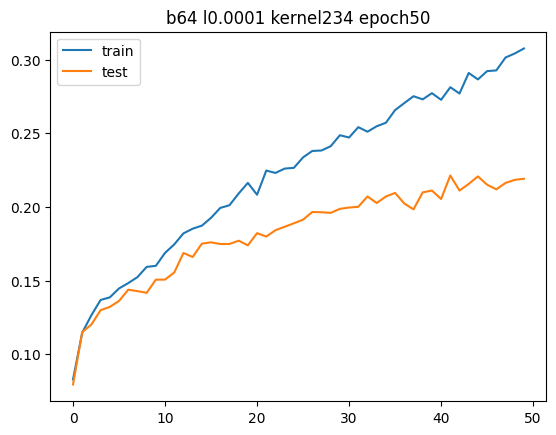

In [34]:
# 模型训练过程结果展示
plt.plot(cnn_train_acc)
plt.plot(cnn_test_acc)

# plt.ylim(ymin=0.5, ymax=1.01)
plt.title("The accuracy of textCNN model")
plt.legend(["train", 'test'])
plt.title("b64 l0.0001 kernel234 epoch50")
plt.savefig('acc-b64 l0.0001 kernel234 epoch50.png')

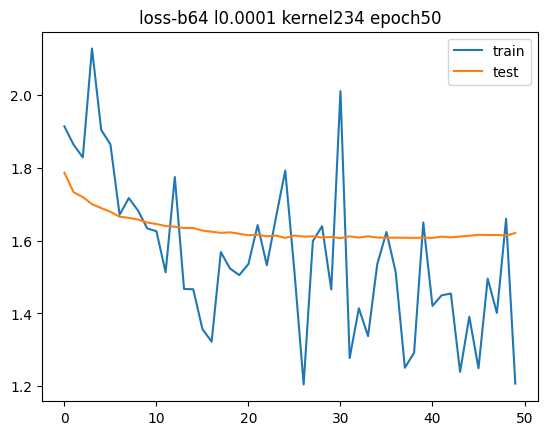

In [35]:
# 模型训练过程结果展示
plt.plot([float(i) for i in cnn_train_loss])
plt.plot([float(i) for i in cnn_test_loss])

# plt.ylim(ymin=0.5, ymax=1.01)
plt.title("The loss of textCNN model")
plt.legend(["train", 'test'])
plt.title("loss-b64 l0.0001 kernel234 epoch50")
plt.savefig('loss-b64 l0.0001 kernel234 epoch50.png')

In [ ]:
b32 l0.0001 kernel23 epoch50 开始就过拟合
b64 l0.0001 kernel23 epoch50 开始就过拟合
b128 l0.0001 kernel23 epoch50 开始就过拟合

In [ ]:
b128 l0.0001 kernel34 epoch100  0.583
b32 l0.0001 kernel345 epoch50 0.583
b64 l0.0001 kernel345 epoch50 0.584


In [31]:
X_train.shape

(23812, 36)

In [25]:
print(cnn)

TextCNN(
  (embedding): Embedding(7103, 50)
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 100, kernel_size=(3, 50), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool2d(kernel_size=(34, 1), stride=(34, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(1, 100, kernel_size=(4, 50), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool2d(kernel_size=(33, 1), stride=(33, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(1, 100, kernel_size=(5, 50), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): MaxPool2d(kernel_size=(32, 1), stride=(32, 1), padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc): Linear(in_features=300, out_features=127, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [38]:
summary(cnn,(256,36),256)

torch.Size([2, 256, 36, 50])
torch.Size([2, 1, 256, 36, 50])


C:\Users\15617\AppData\Local\Temp\ipykernel_2084\2602643122.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.long)


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [2, 1, 256, 36, 50]